In [1]:
'''
Baseline second-order MAML
'''

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns 
from math import pi as PI
import random
import torch.nn as nn
import torch
import random
from higher import innerloop_ctx
import warnings
import importlib

warnings.filterwarnings("ignore")

#Set random seeds for reproducibility of results 
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# set GPU or CPU depending on available hardware
# help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Available device: {device}")

if device == "cuda:0": 
  # set default so all tensors are on GPU, if available
  # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
  torch.set_default_tensor_type('torch.cuda.FloatTensor')

# import backbone model, dataset, and code utils
from models import Neural_Network
from constants import *
from utils import *
import analysis_utils
from data import *

Available device: cpu
Available device: cpu


In [2]:
'''
Create dataset
'''
# specify the number of tasks to sample per meta-set
# note: we end up sampling tasks at random, so sizes are not particularly relevant
# artifact of the way we structured the dataset earlier 
meta_train_size=10000
meta_val_size=1000
meta_test_size=1000
meta_train_eval_size = 20

dataset = RegressionDomain(amp_min=amp_min, amp_max=amp_max, 
                           phase_min=phase_min, phase_max=phase_max, 
                           train_size=meta_train_size, val_size=meta_val_size, test_size=meta_test_size)

meta_val_set = dataset.get_meta_val_batch()
meta_test_set = dataset.get_meta_test_batch()

In [3]:
'''
Handling computation graphs and second-order backprop help and partial inspiration from: 
- https://discuss.pytorch.org/t/how-to-save-computation-graph-of-a-gradient/128286/2 
- https://discuss.pytorch.org/t/when-do-i-use-create-graph-in-autograd-grad/32853/3 
- https://lucainiaoge.github.io/download/PyTorch-create_graph-is-true_Tutorial_and_Example.pdf
- https://www.youtube.com/watch?v=IkDw22a8BDE
- https://discuss.pytorch.org/t/how-to-manually-update-network-parameters-while-keeping-track-of-its-computational-graph/131642/2
- https://discuss.pytorch.org/t/how-to-calculate-2nd-derivative-of-a-likelihood-function/15085/3
- https://pytorch.org/tutorials/recipes/recipes/zeroing_out_gradients.html
- https://higher.readthedocs.io/en/latest/toplevel.html

Neural network configuration and helper class functions copied directly from 
-https://github.com/AdrienLE/ANIML/blob/master/ANIML.ipynb

Note, different ways to refer to the task-specific vs. meta/aggregate updates to the parameters
Sometimes called "inner" and "outer" loop, respectively
Here, refered to as "task_specific" and "agg"/meta" (the latter, for consistency w/ ocariz code)
'''

re_run = False

if re_run: 

    #Instantiate the model network
    model = Neural_Network()
    # move to the current device (GPU or CPU)
    # help from: https://stackoverflow.com/questions/46704352/porting-pytorch-code-from-cpu-to-gpu
    model.to(device)

    N = 1 # number of inner loop steps (notation from: https://www.bayeswatch.com/2018/11/30/HTYM/)
    K = 10 # number of samples to draw from the task

    #Used to store the validation losses
    metaLosses = []
    metaValLosses = []

    #Meta-optimizer for the outer loop
    meta_optimizer = torch.optim.Adam(model.parameters(), lr = lr_meta)

    #Inner optimizer, we were doing this by hand previously
    inner_loop_optimizer = torch.optim.SGD(model.parameters(), lr = lr_task_specific)

    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        # store loss over all tasks to then do a large meta-level update of initial params
        # idea/help from video: https://www.youtube.com/watch?v=IkDw22a8BDE
        meta_loss = None

        waves = dataset.get_meta_train_batch(task_batch_size=T)

        #Loop through all of the tasks
        for i, T_i in enumerate(waves): 
            train_eval_info = task_specific_train_and_eval(model, T_i, inner_loop_optimizer, criterion, K=K, N=N)
            held_out_task_specific_loss = train_eval_info[0]
            if meta_loss is None: 
                meta_loss = held_out_task_specific_loss
            else:
                meta_loss += held_out_task_specific_loss

        meta_optimizer.zero_grad()
        meta_loss /= T
        meta_loss.backward()
        meta_optimizer.step()
        metaLosses.append(meta_loss.item())

        # validation 
        val_wave = dataset.get_meta_val_batch(task_batch_size=1)[0]
        val_train_eval_info = task_specific_train_and_eval(model, val_wave, inner_loop_optimizer, criterion, K=K, N=N)
        val_loss = val_train_eval_info[0]
        metaValLosses.append(val_loss.item())

        if epoch % printing_step == 0:
            print("Iter = ", epoch, " Current Loss", np.mean(metaLosses), " Val Loss: ", np.mean(metaValLosses))
            # saving model help from: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), "baseline_maml.pt")

Iter =  0  Current Loss 3.4673612117767334  Val Loss:  9.870442390441895
Iter =  500  Current Loss 2.6775107029193412  Val Loss:  2.430931439939254
Iter =  1000  Current Loss 2.099873924052918  Val Loss:  1.8805026992035287
Iter =  1500  Current Loss 1.7561043515990051  Val Loss:  1.5828128975991664
Iter =  2000  Current Loss 1.5516697703183502  Val Loss:  1.399199518937802
Iter =  2500  Current Loss 1.4136964658983513  Val Loss:  1.2836757199442173
Iter =  3000  Current Loss 1.3068037558618841  Val Loss:  1.1862075429227263
Iter =  3500  Current Loss 1.221730532628473  Val Loss:  1.1018269308216915
Iter =  4000  Current Loss 1.1522773598409002  Val Loss:  1.0479288447613488
Iter =  4500  Current Loss 1.0945801315135995  Val Loss:  0.996089236699742
Iter =  5000  Current Loss 1.0457755526264436  Val Loss:  0.9517562343584683
Iter =  5500  Current Loss 1.003231240833614  Val Loss:  0.909834199744544
Iter =  6000  Current Loss 0.9649078257380674  Val Loss:  0.877588324961483
Iter =  6500

In [23]:
# torch.save(model.state_dict(), "baseline_maml.pt")

In [4]:
# help from: https://pytorch.org/tutorials/beginner/saving_loading_models.html
model = Neural_Network()
model.load_state_dict(torch.load("baseline_maml.pt"))
criterion = nn.MSELoss()

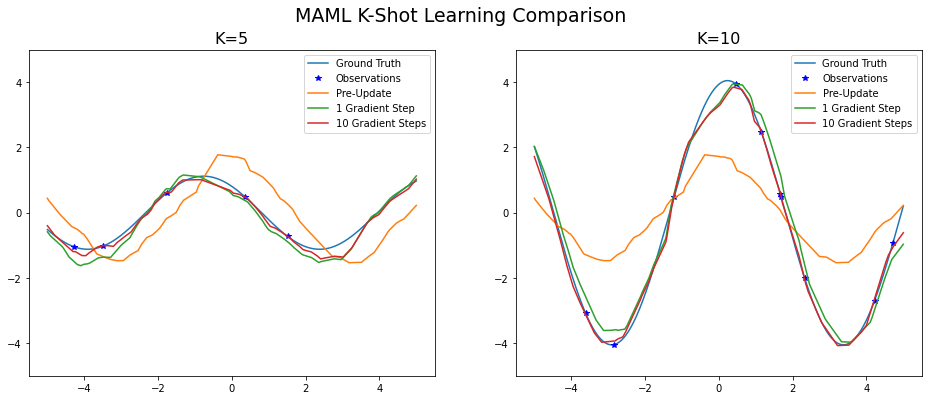

In [5]:
importlib.reload(analysis_utils)

file_tag = "baseline_maml"
plot_lims = [-5.0, 5.0]
analysis_utils.compare_K_shot(model, dataset, criterion, K_vals = [5,10], num_k_shots=10, seed=7,
                              file_tag=file_tag, title="MAML K-Shot Learning Comparison", plot_lims=plot_lims)

Step: 0, Error: 3.0099805807843802, Var: 5.63495282499857
Step: 1, Error: 0.2784293577824719, Var: 0.04588732089335082
Step: 5, Error: 0.08335341039506602, Var: 0.13481166607277625


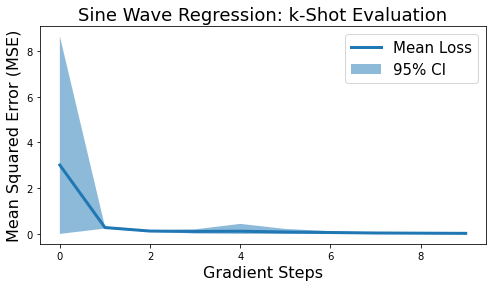

In [6]:
importlib.reload(analysis_utils)

num_k_shots = 10
K = 10
num_eval=1000

res = analysis_utils.k_shot_evaluation(model, dataset, criterion, num_k_shots=num_k_shots, K=K, num_eval=num_eval,
                        file_tag=file_tag, seed=7)

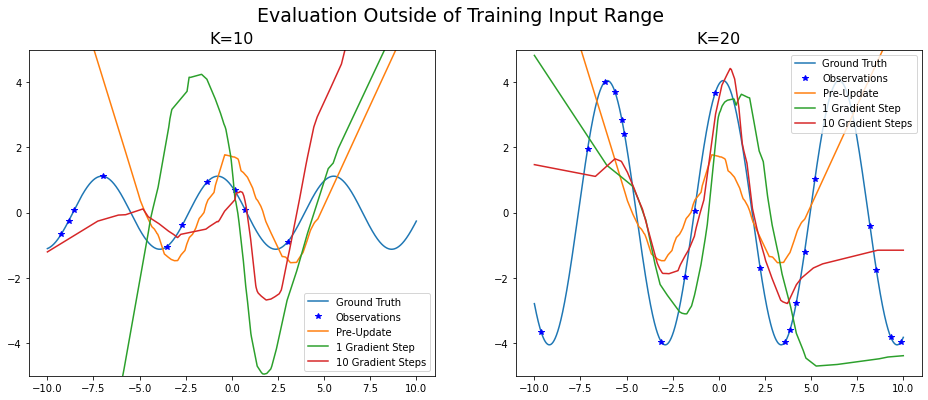

In [14]:
'''
Draw ood samples
'''
importlib.reload(analysis_utils)
wave = dataset.get_meta_test_batch(task_batch_size=1)[0]
ood_range = [-10, 10] # includes some in-dist and ood

file_tag = "ood_x_maml"
plot_lims = [-5.0, 5.0]
analysis_utils.compare_K_shot(model, dataset, criterion, K_vals = [10,20], num_k_shots=10, seed=7,
                              file_tag=file_tag, title="Evaluation Outside of Training Input Range", plot_lims=plot_lims,
                             input_range=ood_range, legend_locs=["lower right", "upper right"])

In [19]:
'''
Draw ood samples
'''
wave = dataset.get_meta_test_batch(task_batch_size=1)[0]
ood_range = [-5, 10] # includes some in-dist and ood
with_noise = False
noise_dev = 1
num_samples = 50

# pulling out data generation from custom-written data.py, get_samples
eval_coords = [random.uniform(ood_range[0], ood_range[1]) for _ in range(num_samples)]
y_true = [wave.draw_sample(x,with_noise=with_noise,noise_dev=noise_dev) for x in eval_coords]
eval_coords = torch.Tensor(eval_coords)
y_true=torch.Tensor(y_true)
# following format of get_samples_in_good_format
eval_coords = torch.tensor(eval_coords[:,None])
y_true = torch.tensor(y_true[:,None])

# get preds and prep for plotting
# modified from custom-written task_specific_train_and_eval
task_preds = model(eval_coords)

eval_coords = eval_coords.detach().numpy()[:,0]
task_preds = task_preds.detach().numpy()[:,0]
pred_data = sorted([(x, y) for (x, y) in zip(eval_coords, task_preds)], key=lambda x: x[0])


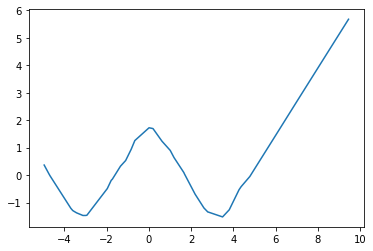

In [20]:
plt.plot([x[0] for x in pred_data], [x[1] for x in pred_data])

In [37]:
num_samples = 10

eval_coords = [random.uniform(ood_range[0], ood_range[1]) for _ in range(num_samples)]
y_true = [wave.draw_sample(x,with_noise=with_noise,noise_dev=noise_dev) for x in eval_coords]
eval_coords = torch.Tensor(eval_coords)
y_true=torch.Tensor(y_true)
# following format of get_samples_in_good_format
x = torch.tensor(eval_coords[:,None])
label = torch.tensor(y_true[:,None])

extract_task_info = True
task_info = {}

if extract_task_info == True: 
    input_coords = x.detach().numpy()[:,0]
    true_vals = sorted([(x, y) for (x, y) in zip(input_coords, label)], key=lambda x: x[0])

    task_info["input_coords"] = input_coords
    task_info["gt"] = true_vals

    # generate more points for a fine-grained evaluation of underlying func
    eval_x, eval_true_y = get_samples_in_good_format(T_i,num_samples=10000)

    eval_coords = eval_x.detach().numpy()[:,0]
    task_info["eval_coords"] = eval_coords
    task_info["gt_func"] = sorted([(x, y) for (x, y) in zip(eval_coords, eval_true_y)], key=lambda x: x[0])

#Description of the loop formulation from https://higher.readthedocs.io/en/latest/toplevel.html
with innerloop_ctx(model, inner_loop_optimizer, copy_initial_weights = False) as (fmodel,diffopt):
    #get our input data and our label
    per_step_loss = []
    for grad_step in range(N):

        if extract_task_info: 
            # use preds for new points
            preds_eval = fmodel(eval_x)
            task_preds = preds_eval.detach().numpy()[:,0]
            pred_data = sorted([(x, y) for (x, y) in zip(eval_coords, task_preds)], key=lambda x: x[0])
            task_info[f"preds_{grad_step}"] = pred_data

        preds = fmodel(x)
        #Get the task specific loss for our model
        task_specifc_loss = criterion(preds, label)

        #Step through the inner gradient
        diffopt.step(task_specifc_loss)

        per_step_loss.append(task_specifc_loss.item())

    held_out_task_specific_loss = evaluation(fmodel, T_i, criterion, K=K)


TypeError: evaluation() got an unexpected keyword argument 'K'